# COMP 352 Final Project - Blackjack

**Authors:** Joe Cox, Augusto Escudero, Hreinson Vanover

**Date:** 12/15/2024

## Table of Contents:
* [Data Importing and Pre-processing](#data-importing)
* [Data Analysis and Visualization](#data-vis)
* [Data Analytics](#data-analytics)

## Data Importing and Pre-processing <a class="anchor" id="data-importing"></a>

In [2]:
# Import needed libraries
import pandas as pd
from pandas import DataFrame

import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

In [3]:
# Read in csv file
# Using local file instead of uploading to repository
# Size is 3.63GB

# Import dataset into Pandas DataFrame
entire_blackjack_df = pd.read_csv("blackjack_simulator.csv", nrows=1000000)


In [5]:
# Describing characteristics

blackjack_df = entire_blackjack_df

print("Dataset shape (rows, columns): ", blackjack_df.shape)

numerical_columns = blackjack_df.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = blackjack_df.select_dtypes(include=['object', 'category']).columns

print('\nColumn types:')
print('---'*3)
print('Number of numerical variables: ', len(numerical_columns))
print('Number of categorical variables: ', len(categorical_columns))
print('---'*3)

print("\nData types: ")
print("---"*3)
print(blackjack_df.dtypes)

Dataset shape (rows, columns):  (1000000, 12)

Column types:
---------
Number of numerical variables:  6
Number of categorical variables:  6
---------

Data types: 
---------
shoe_id                 int64
cards_remaining         int64
dealer_up               int64
initial_hand           object
dealer_final           object
dealer_final_value     object
player_final           object
player_final_value     object
actions_taken          object
run_count               int64
true_count              int64
win                   float64
dtype: object


In [7]:
# Check column names
blackjack_df.columns

Index(['shoe_id', 'cards_remaining', 'dealer_up', 'initial_hand',
       'dealer_final', 'dealer_final_value', 'player_final',
       'player_final_value', 'actions_taken', 'run_count', 'true_count',
       'win'],
      dtype='object')

In [8]:
blackjack_df.head()

,shoe_id,cards_remaining,dealer_up,initial_hand,dealer_final,dealer_final_value,player_final,player_final_value,actions_taken,run_count,true_count,win
0,0,416,10,"[10, 11]","[10, 4, 10]",24,"[[10, 11]]",['BJ'],[['S']],1,0,1.5
1,0,411,10,"[5, 5]","[10, 8]",18,"[[5, 5, 11]]",[21],"[['H', 'S']]",-2,0,1.0
2,0,406,6,"[3, 10]","[6, 6, 10]",22,"[[3, 10]]",[13],[['S']],-2,0,1.0
3,0,401,10,"[5, 9]","[10, 8]",18,"[[5, 9, 11, 3]]",[18],"[['H', 'H', 'S']]",-1,0,0.0
4,0,395,8,"[6, 10]","[8, 2, 10]",20,"[[6, 10, 10]]",[26],[['H']],-1,0,-1.0


### Handling missing data

In [9]:
total = blackjack_df.isnull().sum().sort_values(ascending=False)
percent = (blackjack_df.isnull().sum() / blackjack_df.isnull().count()).sort_values(
    ascending=False
)

missing_data = pd.concat([total, percent], axis=1, keys=["Total", "Percent"])
missing_data.head(20)

,Total,Percent
shoe_id,0,0.0
cards_remaining,0,0.0
dealer_up,0,0.0
initial_hand,0,0.0
dealer_final,0,0.0
dealer_final_value,0,0.0
player_final,0,0.0
player_final_value,0,0.0
actions_taken,0,0.0
run_count,0,0.0


Note that there is no missing data

### Transform the Data

#### Label encode categorical variables

In [50]:
# Create a mapping dictionary
# S = Stand , H = Hit , D = Double , P = Split , R = Surrender , I = Insurance , N = No Insurance, ] = No move(dealer had BJ)
mapping = {'S': 0, 'H': 1, 'D': 2, 'P': 3, 'R': 4, 'I': 5, 'N': 6, ']': 7}

# Apply mapping to the column
blackjack_df['first_move'] = blackjack_df['actions_taken'].str[3].map(mapping)

check_df = blackjack_df[["actions_taken", "first_move"]]
print(check_df.head)

<bound method NDFrame.head of             actions_taken  first_move
0                 [['S']]           0
1            [['H', 'S']]           1
2                 [['S']]           0
3       [['H', 'H', 'S']]           1
4                 [['H']]           1
...                   ...         ...
999995  [['H', 'H', 'S']]           1
999996            [['S']]           0
999997       [['H', 'S']]           1
999998            [['S']]           0
999999  [['H', 'H', 'S']]           1

[1000000 rows x 2 columns]>


#### Preform Feature Construction

In [51]:
items = blackjack_df['initial_hand']
item = items[0]
print(items)

print(type(item))

blackjack_df[['left_number', 'right_number']] = blackjack_df['initial_hand'].str.strip('[]').str.split(', ', expand=True).astype(int)

0         [10, 11]
1           [5, 5]
2          [3, 10]
3           [5, 9]
4          [6, 10]
            ...   
999995      [3, 2]
999996     [7, 10]
999997      [3, 2]
999998     [9, 10]
999999     [11, 4]
Name: initial_hand, Length: 1000000, dtype: object
<class 'str'>


In [183]:
# Define conditions and choices
conditions = [
    blackjack_df['win'] > 0,
    blackjack_df['win'] == 0,
    blackjack_df['win'] < 0,
]
choices = [1, 0, -1]

# Apply the conditions to create a new column
blackjack_df['win_encoded'] = np.select(conditions, choices)

In [184]:
blackjack_df['player_hand_total'] = blackjack_df['left_number'] + blackjack_df['right_number']

In [185]:
# drop duplicate rows
print(blackjack_df.shape)
blackjack_df = blackjack_df.drop_duplicates()
print(blackjack_df.shape)
# there is none

(1000000, 17)
(1000000, 17)


In [187]:
# remove unnecessary columns
filtered_blackjack_df = blackjack_df.drop(columns=["shoe_id", "cards_remaining", "dealer_final", "dealer_final_value", "player_final", "player_final_value", "actions_taken", "run_count", "true_count", 'initial_hand'])

na_columns_count = filtered_blackjack_df.isnull().any().sum()
print(na_columns_count)

rows_with_na = filtered_blackjack_df[filtered_blackjack_df.isnull().any(axis=1)]
print(rows_with_na)

0
Empty DataFrame
Columns: [dealer_up, win, first_move, left_number, right_number, win_encoded, player_hand_total]
Index: []


## Data Analysis and Visualization <a class="anchor" id="data-vis"></a>

--- Statistics for dealer_up ---
Mean: 7.3014
Median: 8.0000
Standard Deviation: 2.9196
Min: 2, Max: 11




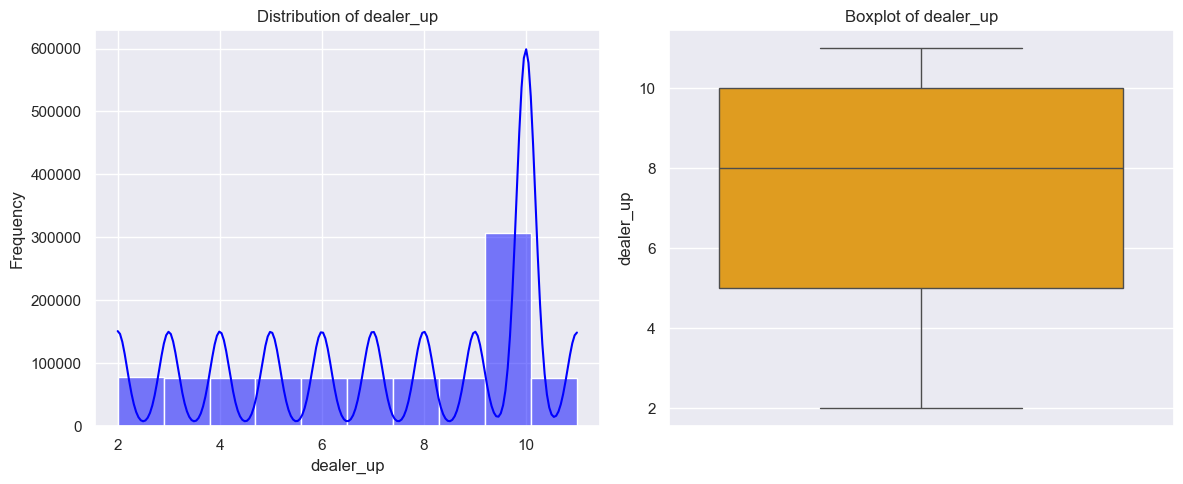

--- Statistics for win ---
Mean: -0.0057
Median: 0.0000
Standard Deviation: 1.1458
Min: -7.0, Max: 7.0




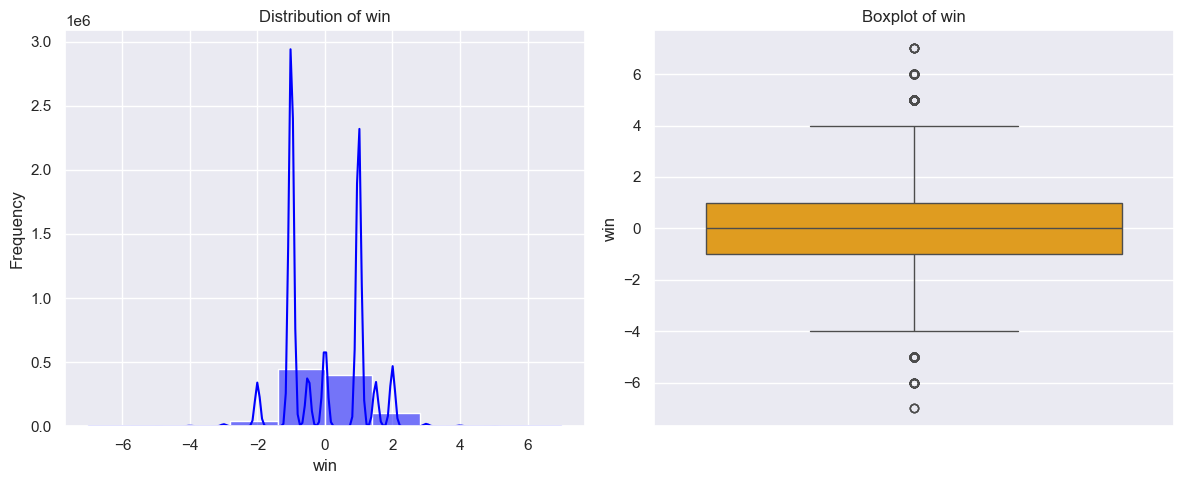

--- Statistics for first_move ---
Mean: 1.3767
Median: 1.0000
Standard Deviation: 1.8994
Min: 0, Max: 7




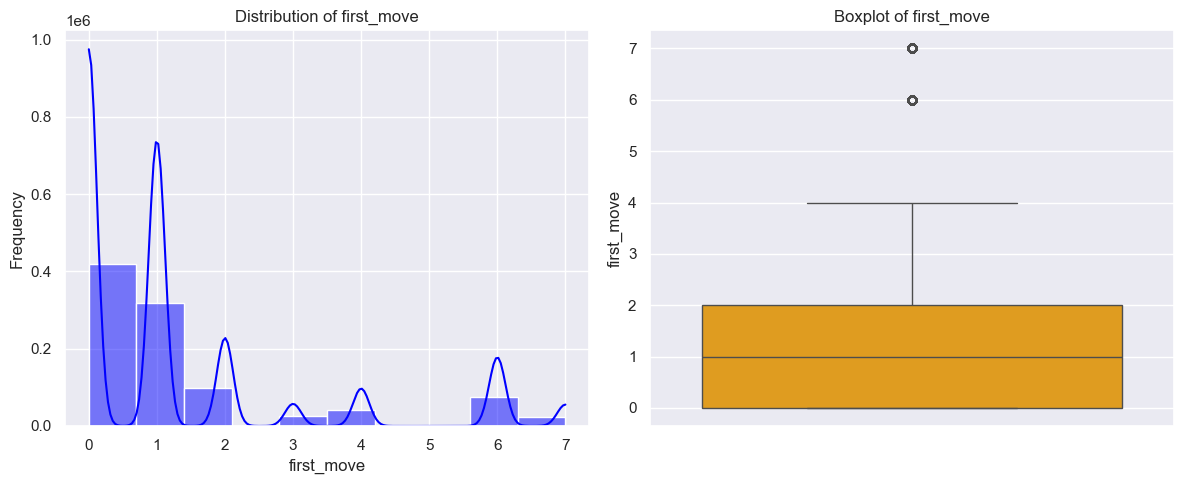

--- Statistics for left_number ---
Mean: 7.3064
Median: 8.0000
Standard Deviation: 2.9196
Min: 2, Max: 11




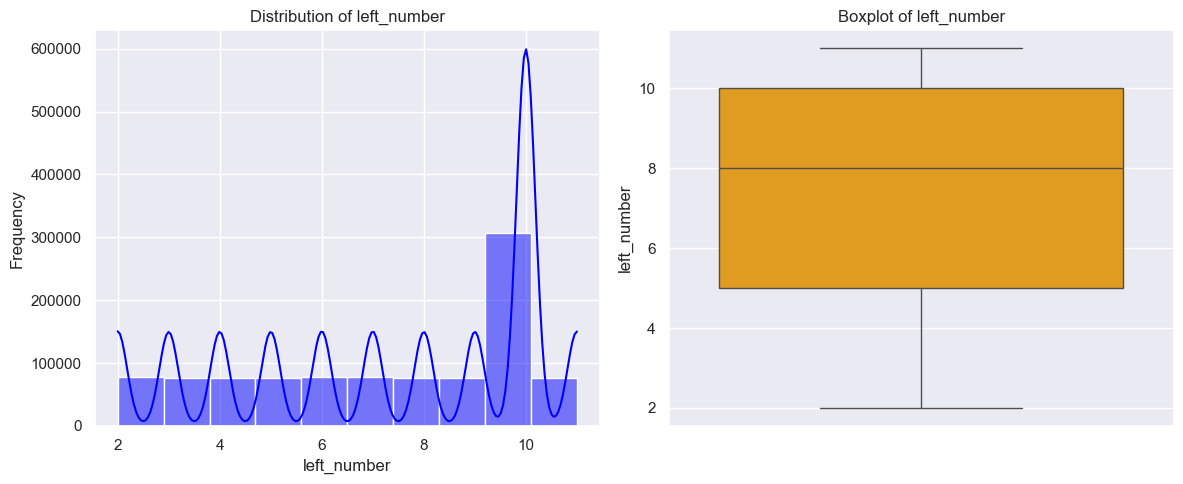

--- Statistics for right_number ---
Mean: 7.3103
Median: 8.0000
Standard Deviation: 2.9201
Min: 2, Max: 11




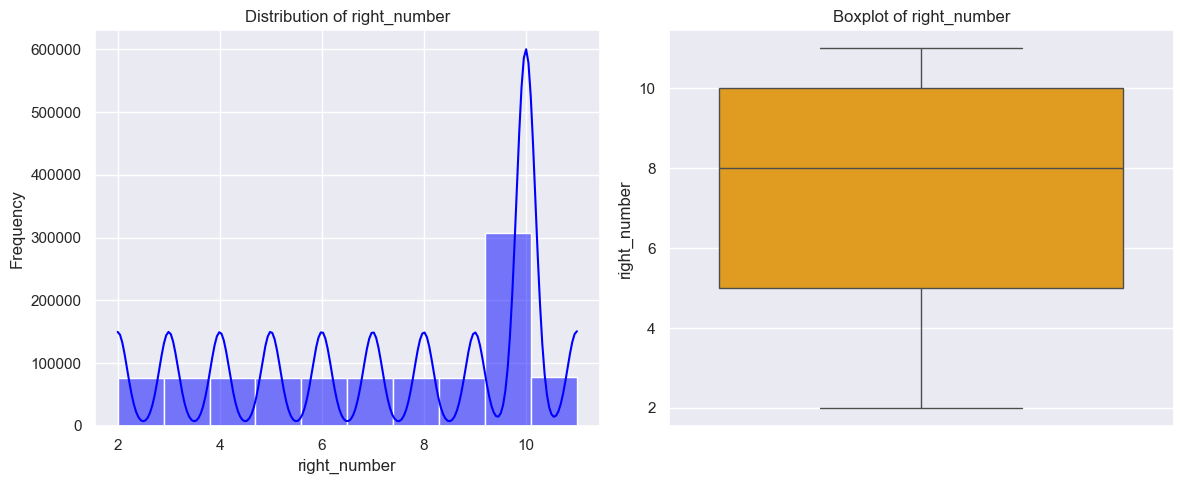

--- Statistics for win_encoded ---
Mean: -0.0728
Median: 0.0000
Standard Deviation: 0.9544
Min: -1, Max: 1




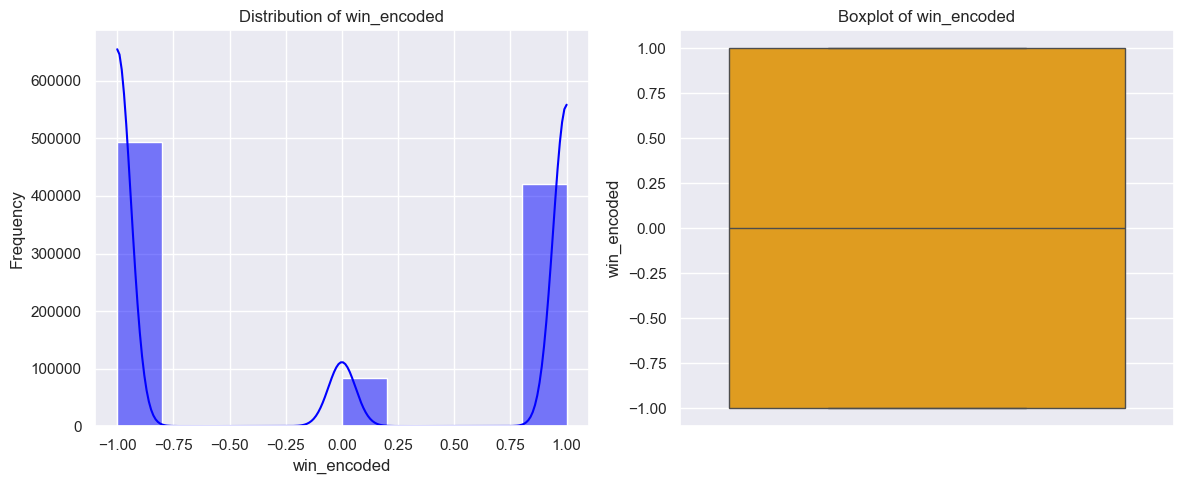

--- Statistics for player_hand_total ---
Mean: 14.6167
Median: 15.0000
Standard Deviation: 4.1238
Min: 4, Max: 22




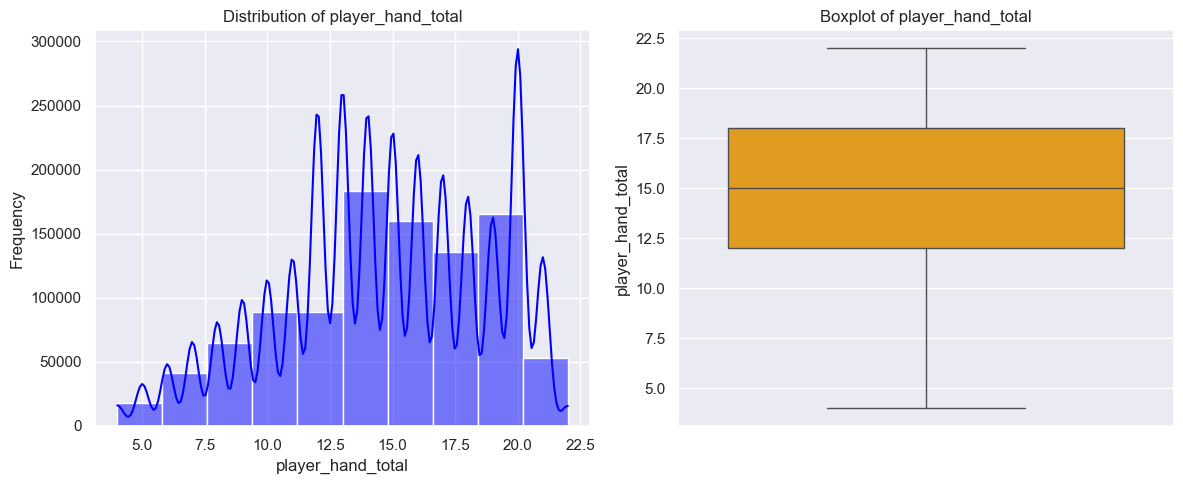

In [188]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Function to calculate measures of centrality and distribution
def display_statistics_and_visuals(df, column):
    print(f"--- Statistics for {column} ---")
    print(f"Mean: {df[column].mean():.4f}")
    print(f"Median: {df[column].median():.4f}")
    print(f"Standard Deviation: {df[column].std():.4f}")
    print(f"Min: {df[column].min()}, Max: {df[column].max()}")
    print("\n")
    
    # Plot Histogram and KDE
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(df[column], kde=True, bins=10, color='blue')
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    
    # Plot Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[column], color='orange')
    plt.title(f"Boxplot of {column}")
    plt.ylabel(column)
    
    plt.tight_layout()
    plt.show()

# Analyze columns
columns_to_analyze = ['dealer_up', 'win', 'first_move', 'left_number', 'right_number', 'win_encoded', 'player_hand_total']

for col in columns_to_analyze:
    display_statistics_and_visuals(filtered_blackjack_df, col)


/opt/anaconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


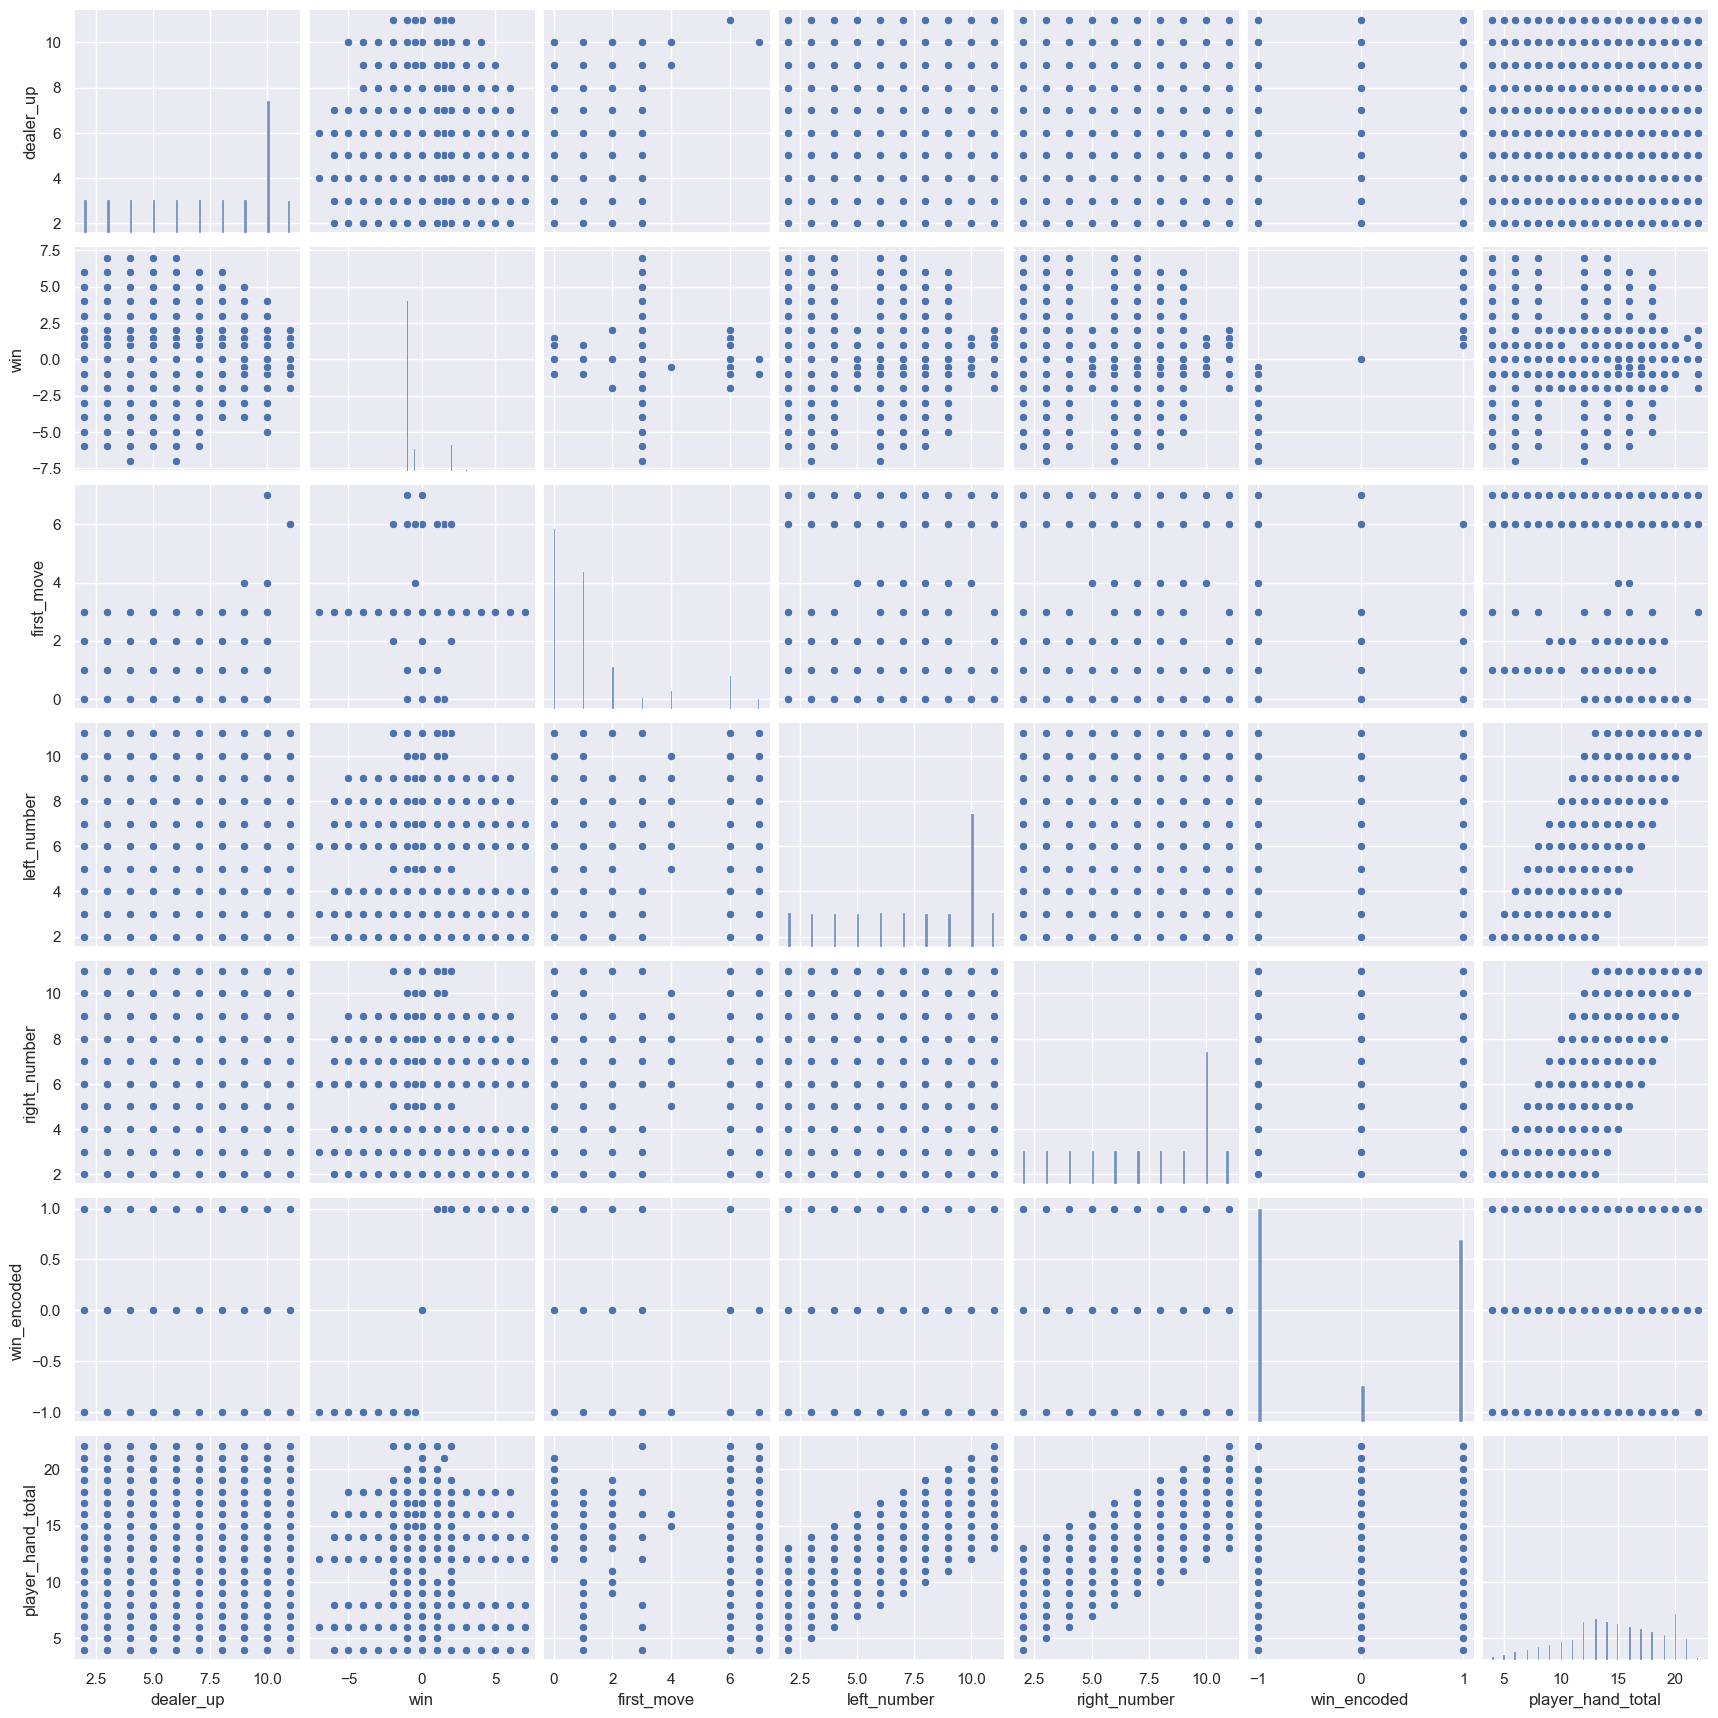

In [189]:
# scatterplot
sns.set()
cols = [
    "dealer_up",
    "win",
    "first_move",
    "left_number",
    "right_number",
    "win_encoded",
    "player_hand_total"
]
sns.pairplot(filtered_blackjack_df[cols], size=2.5)
plt.show()

Correlation Matrix

<Axes: >

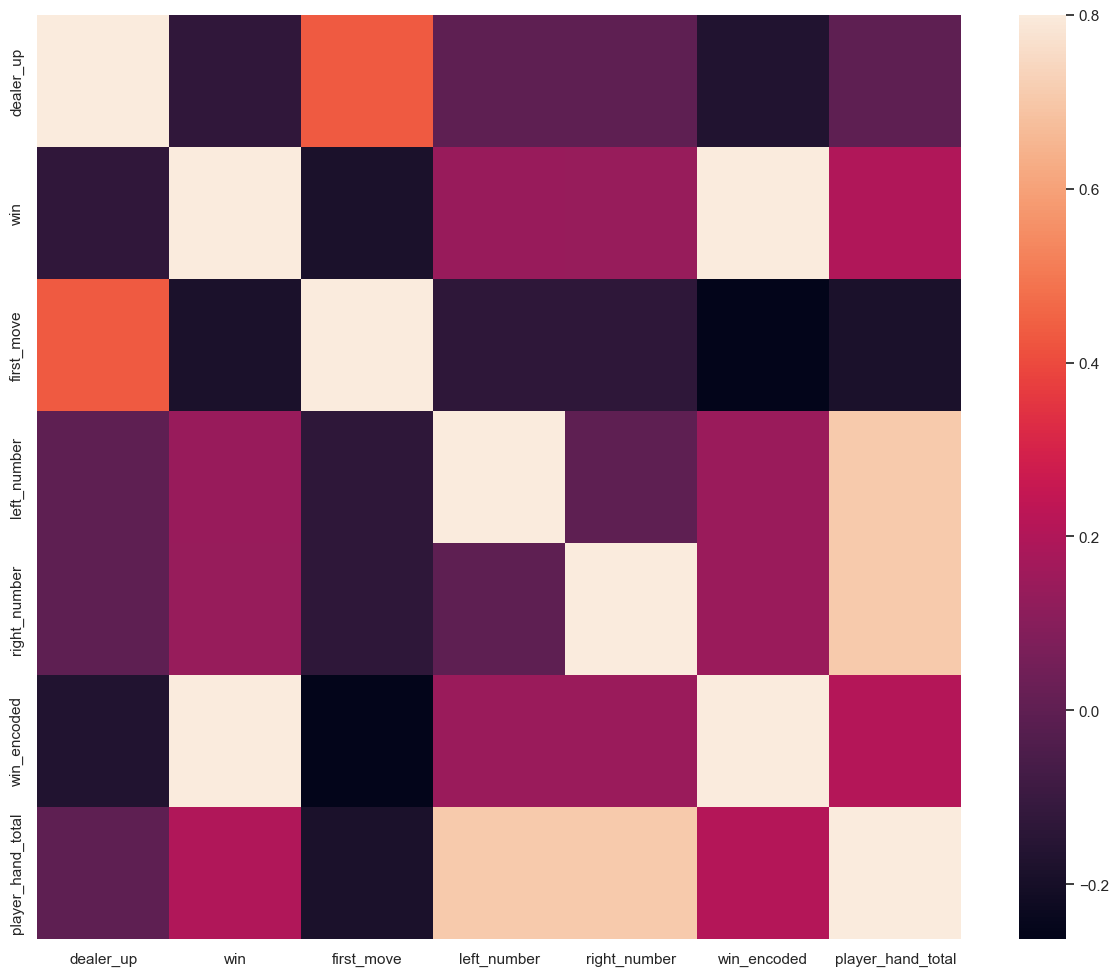

In [190]:
corrmat = filtered_blackjack_df.corr()
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(corrmat, vmax=0.8, square=True)

identify stuff
Diagnose for correlations between variables and determine independent and dependent variables

## Data Analytics <a class="anchor" id="data-analytics"></a>

In [191]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Features and target
X = filtered_blackjack_df[['dealer_up', 'first_move', 'left_number', 'right_number', 'player_hand_total']]
y = filtered_blackjack_df['win_encoded']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Multinomial Logistic Regression
logreg = LogisticRegression(class_weight='balanced', multi_class='multinomial', solver='lbfgs')
logreg.fit(X_train, y_train)

# Predictions
y_pred = logreg.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(report)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.44

Confusion Matrix:
[[46098 25007 27678]
 [ 5719  7100  4003]
 [25074 23940 35381]]

Classification Report:
              precision    recall  f1-score   support

          -1       0.60      0.47      0.52     98783
           0       0.13      0.42      0.19     16822
           1       0.53      0.42      0.47     84395

    accuracy                           0.44    200000
   macro avg       0.42      0.44      0.40    200000
weighted avg       0.53      0.44      0.47    200000



#### Algotithm Results on a 5 Fold Cross Validation

In [192]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Perform 5-Fold Cross Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(logreg, X, y, cv=cv, scoring='accuracy')

# Output Results
print(f"Cross Validation Scores: {scores}")
print(f"Mean Accuracy: {scores.mean():.4f}")
print(f"Standard Deviation: {scores.std():.4f}")

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in ve

Cross Validation Scores: [0.44244  0.44358  0.44312  0.443965 0.44229 ]
Mean Accuracy: 0.4431
Standard Deviation: 0.0006


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.64

Confusion Matrix:
[[84407     0 14936]
 [ 9066     0  7507]
 [40819     0 43265]]

Classification Report:
              precision    recall  f1-score   support

          -1       0.63      0.85      0.72     99343
           0       0.00      0.00      0.00     16573
           1       0.66      0.51      0.58     84084

    accuracy                           0.64    200000
   macro avg       0.43      0.45      0.43    200000
weighted avg       0.59      0.64      0.60    200000



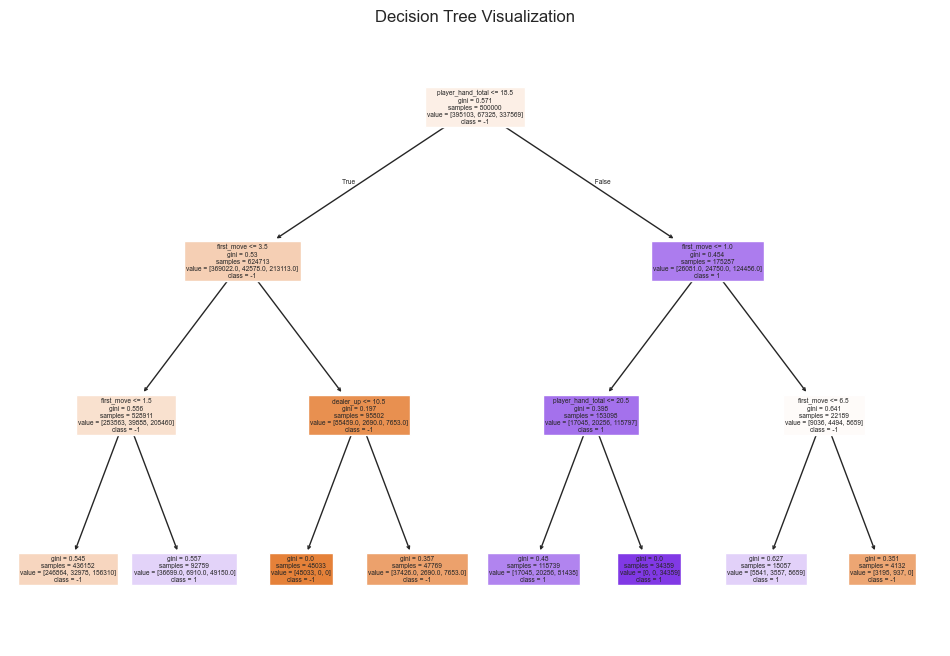

In [200]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn import tree

# Step 1: Define Features and Target
X = filtered_blackjack_df[['dealer_up', 'first_move', 'left_number', 'right_number', 'player_hand_total']]
y = filtered_blackjack_df['win_encoded']

# Step 2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Step 3: Initialize and Train Decision Tree Model
dt_model = DecisionTreeClassifier(criterion='gini', max_depth=3)
dt_model.fit(X_train, y_train)

# Step 4: Make Predictions
y_pred = dt_model.predict(X_test)

# Step 5: Evaluate the Model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(report)

# Step 6: Visualize the Decision Tree
plt.figure(figsize=(12, 8))
tree.plot_tree(dt_model, feature_names=X.columns, class_names=['-1', '0', '1'], filled=True)
plt.title("Decision Tree Visualization")
plt.show()


In [201]:
# Perform 5-Fold Cross Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(dt_model, X, y, cv=cv, scoring='accuracy')

# Output Results
print(f"Cross Validation Scores: {scores}")
print(f"Mean Accuracy: {scores.mean():.4f}")
print(f"Standard Deviation: {scores.std():.4f}")

Cross Validation Scores: [0.638325 0.636165 0.63684  0.63679  0.63586 ]
Mean Accuracy: 0.6368
Standard Deviation: 0.0009
